# Wasserstein Auto-Encoders

@Author Juanwu Lu

@Date   Dec-20-22

The Wasserstein Auto-Encoders (WAE) were first proposed by Ilya et al. in their paper ["Wasserstein Auto-Encoders"](https://arxiv.org/abs/1711.01558). The proposed algorithm uses a Wasserstein distance between the model distribution and the target distribution to construct a penalized regularizer. Compared to the classic regularizer used by other Variational Auto-Encoders (VAEs), the proposed one encourages __the encoded trainig distribution to match the prior__.

## Preliminaries

Following the classic formulation for generative models, the problem is to solve for an __optimal statistic model__ $P_G$, which minimizes a certain discrepancy measures between the commonly unknown data distribution prior $P_X$ and the model $P_G$. The proposed WAE approaches generative modeling from the optimal transport (OT) perspective. It uses Kantorovich-Rubinstein duality to express an adversarial objective.

### Kantorovich-Rubinstein Duality

Generally, the discrepancy between probability distributions $P_X$ and $P_G$ can be measured using $f$-_divergence_ defined by $D_f(P_X||P_G):=\int f(\frac{p_X(x)}{p_G(x)})p_G(x)dx$, where $f:(0,\infty)\rightarrow\mathbb{R}$ is any __convex function__ satisfying $f(1)=0$. The Kullback-Leibler $D_{KL}$ and Jensen-Shannon $D_{JS}$ divergences are the two typical examples.

The rich class of divergences is induced by the _optimal transport_ (OT) problem. The Kantorovich's formulation of the problem is given by
$$
    W_c(P_X, P_G):=\inf_{\Gamma\in\mathcal{P}(X\sim P_X, Y\sim P_G)}\mathbb{E}_{(X, Y)\sim\Gamma}\left[c(X, Y)\right],
$$
where $c(X, Y):\mathcal{X}\times\mathcal{X}\rightarrow\mathbb{R}_+$ is anymeasurable _cost function_ and $\mathcal{P}(X\sim P_X, Y\sim P_G)$ is a set of all joint distributions of $(X, Y)$ with marginals $P_X$ and $P_G$.

Consider the case with a metric space $(\mathcal{X}, d)$ and $c(x,y)=d^p(x, y),\quad p\geq 1$, the $p$-th root of $W_c$ given by $W_p$ is the $p$-_Wasserstein distance_. Specially, when $p=1$ and $c(x,y)=d(x,y)$, a __Kantorovich-Rubinstein duality__ holds:
$$
    W_1(P_X, P_G)=\sup_{f\in\mathcal{F}_L}\mathbb{E}_{X\in P_X}\left[f(X)\right] - \mathbb{E}_{Y\in P_G}\left[f(Y)\right],
$$
where $\mathcal{F}_L$ is the class of all bounded $1$-Lipschitz functions on $(\mathcal{X}, d)$.

### Generative Model: Wasserstein Auto-Encoders

The proposed model is built upon the concept of _latent variable models_. Results $Y$ is generated using $Z$ sampled from a fixed distribution $P_Z$ on a latent space $\mathcal{Z}$. The mapping is a __deterministic function__ $X=G(Z)$. Instead of finding the coupling $\Gamma\sim\mathcal{P}(X\sim P_X, Y\sim P_Y)$, it's sufficient to find a conditional distribution $Q(Z|X)$ s.t. its $Z$ marginal $Q_Z(Z):=\mathbb{E}_{X\sim P_X}\left[Q(Z|X)\right]$ is identical to the prior distribution $P_Z$. Therefore, the WAE ojective is given by
$$
    D_{WAE}(P_X, P_G):=\inf_{Q(Z|X)\in\mathcal{Q}}\mathbb{E}_{P_X}\mathbb{E}_{Q(Z|X)}\left[c(X, G(Z))\right]+\lambda\cdot\mathcal{D}_Z(Q_Z, P_Z)
$$

Two proposed formulation of the divergence $\mathcal{D}_Z(Q_Z, P_Z)$ are __GAN-based__ $\mathcal{D}_Z$ and __MMD-based__ $\mathcal{D}_Z$.

In [16]:
from __future__ import annotations

import math
import os
import random
import time
from collections import OrderedDict
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import torch as th
import torchvision
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from utils import AverageTrackerGroup

## Experiment Setup

In the original paper, they used Euclidian latent spaces $\mathcal{Z}=\mathbb{R}^{d_z}$ for various dimensinalities $d_z$ depending on the complexity of the dataset, with isotropic Gaussian prior distributions $P_Z(Z)=\mathcal{N}(Z; 0, \sigma_z^2\cdot \mathbf{I}_d)$ over $\mathcal{Z}$, and a squared cost function $c(x, y)=\left\|x-y\right\|_2^2$ for data points $x,y\in\mathbb{R}^{d_x}$.

### Dataset

Two real-world datasets are used in the experiments: MNIST consisting of 70k images, and CelebA consisting of roughly 203k images. However, since the API for CelebA in PyTorch is unstable, this notebook only investigate the MNIST dataset.

In [2]:
# MNIST Dataset
mnist_train_set = torchvision.datasets.MNIST(
    root='../data', train=True, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)
mnist_test_set = torchvision.datasets.MNIST(
    root='../data', train=False, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

# CelebA Datset
# celeba_train_set = torchvision.datasets.CelebA(
#     root='../data', split='train', download=True,
#     transform=torchvision.transforms.Compose([
#         torchvision.transforms.Resize(64),
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ])
# )
# celeba_test_set = torchvision.datasets.CelebA(
#     root='../data', split='test', download=True,
#     transform=torchvision.transforms.Compose([
#         torchvision.transforms.Resize(64),
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ])
# )

### Modeling

The original model used _deterministic_ encoder-decoder pairs with convolutional deep neural network architectures for encoder mapping $\mu_\phi:\mathcal{X}\rightarrow\mathcal{Z}$ and decoder mapping $G_\theta:\mathcal{Z}\rightarrow\mathcal{X}$ similar to the DCGAN paper with batch normalization.

In [3]:
class Encoder(th.nn.Module):
    """Encoder model for the Wasserstein VAE.

    Attributes:
        in_shape: The shape of input image.
        hidden_channels: The integer size of the final convolutional layer.
        latent_size: The integer dimensionality of the latent variable.
        num_layers: The total number of convolutional layers.
        batch_norm: A boolean flag if apply batch normalization.
        batch_norm_eps: A float shifts for batch normalization denominator.
    """

    def __init__(self,
                 in_shape: List[int],
                 hidden_channels: int = 1024,
                 num_layers: int = 4,
                 latent_size: int = 8,
                 batch_norm: bool = True,
                 batch_norm_eps: float = 1e-5) -> None: 
        super().__init__()

        self.in_shape = in_shape
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.latent_size = latent_size
        self.batch_norm = batch_norm
        self.batch_norm_eps = batch_norm_eps

        self.conv_layers = th.nn.Sequential()
        in_channels = in_shape[0]
        for i in range(num_layers):
            scale = 2 ** (num_layers - i - 1)
            self.conv_layers.add_module(
                f'conv2d_{i+1:d}',
                th.nn.Conv2d(in_channels, hidden_channels // scale,
                             kernel_size=4, stride=2, padding=1, bias=True)
            )
            if batch_norm and i != num_layers - 1:
                self.conv_layers.add_module(
                    f'batch_norm_{i+1:d}',
                    th.nn.BatchNorm2d(
                        hidden_channels // scale, eps=batch_norm_eps
                    )
                )
            self.conv_layers.add_module(
                f'relu_{i+1:d}',
                th.nn.ReLU(inplace=True)
            )
            in_channels = hidden_channels // scale

        self.linear = th.nn.Linear(int(np.prod(self.conv_out())), latent_size)

    def forward(self, x: th.Tensor) -> th.Tensor:
        x = x.float()
        batch_size = x.shape[0]

        output = self.conv_layers.forward(x)
        output = output.view(batch_size, -1)
        output = self.linear.forward(output)

        return output

    def conv_out(self) -> List[int]:
        _input = th.zeros(1, *self.in_shape)
        _output = self.conv_layers.forward(_input)
        return list(_output.shape[1:])

In [4]:
class Decoder(th.nn.Module):
    """Decoder model for the Wasserstein VAE.
    
    Attributes:
        in_features: The integer dimensionality of the latent space.
        conv_size: The shape of convolutional layers output for encoder.
        num_layers: An integer number of convolutional layers.
    """

    def __init__(self,
                 in_features: int,
                 conv_size: List[int],
                 num_layers: int = 4,
                 batch_norm: bool = True,
                 batch_norm_eps: float = 1e-5) -> None:
        super().__init__()

        self.in_features = in_features
        self.conv_size = conv_size
        self.num_layers = num_layers
        self.batch_norm = batch_norm
        self.batch_norm_eps = batch_norm_eps

        self.up_proj = th.nn.Sequential(OrderedDict([
            ('linear_1', th.nn.Linear(
                in_features, int(np.prod(self.conv_size))
            )),
            ('relu_1', th.nn.ReLU(True))
        ]))
        self.unconv_layers = th.nn.Sequential()
        in_channels = conv_size[0]
        for i in range(num_layers):
            if batch_norm and i != 0:
                self.unconv_layers.add_module(
                    f'batch_norm_{i+1:d}',
                    th.nn.BatchNorm2d(in_channels,
                                      eps=batch_norm_eps)
                )
            self.unconv_layers.add_module(
                f'unconv2d_{i+1:d}',
                th.nn.ConvTranspose2d(
                    in_channels, int(in_channels / 2),
                    kernel_size=4, stride=2, padding=1,
                    output_padding=1 if i < 2 else 0
                )
            )
            self.unconv_layers.add_module(
                f'relu_{i+1:d}',
                th.nn.ReLU(inplace=True)
            )
            in_channels = int(in_channels / 2)
        self.unconv_layers.add_module(
            f'unconv2d_{num_layers:d}',
            th.nn.ConvTranspose2d(
                in_channels * 2, 1,
                kernel_size=4, stride=2, padding=1
            )
        )
        self.unconv_layers.add_module(
            f'sigmoid',
            th.nn.Sigmoid()
        )

    def forward(self, z: th.Tensor) -> th.Tensor:
        z = z.float()
        batch_size = z.shape[0]

        output = self.up_proj.forward(z)
        output = output.view(batch_size, *self.conv_size)
        output = self.unconv_layers.forward(output)

        return output

### Run the Experiment



In [5]:
# ===Dataset Arguments===
in_shape: List[int] = [1, 28, 28]  # Change according to dataset
batch_size = 100

# ===Model Arguments===
arch: str = 'gan'
device = th.device('cuda:0')
e_hidden_channels: int = 1024
e_num_layers: int = 4
g_num_layers: int = 4
d_hidden_size: int = 512
d_num_layers: int = 4
wae_lambda: float = 10.0

# ===Latent Space Configuration===
latent_size: int = 8  # Change according to dataset
pz_type: str = 'gaussian'
pz_scale: float = 1.0

# ===Train Arguments===
adam_betas: Tuple[float, float] = (0.5, 0.999)
cost_type: str = 'l2'
grad_clip: Optional[float] = 1.0
lr: float = 0.001
num_epoch: int = 100
log_frequency: int = 200
save_frequency: int = 20

# ===Reproducibility===
seed: int = 42
th.manual_seed(seed)
np_rng = np.random.default_rng(seed)
th_rng = th.Generator().manual_seed(seed)

def worker_init_fn(worker_id: int) -> None:
    worker_seed = th.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

#### GAN-based Penalty Algorithm

The GAN-style WAE uses an additional Discriminator model $D$ composed of several fully coneected layers with ReLU.

__Require__: Regularization coefficient $\lambda>0$.
1. Initialize the parameters of the encoder $Q_\phi$, decoder $G_\theta$, and latent discriminator $D_\gamma$.
2. __while__ ($\phi$, $\theta$) not converged __do__
   1. Sample $\{x_1,\ldots,x_n\}$ from the training set.
   2. Sample $\{z_1,\ldots,z_n\}$ from the prior $P_Z$.
   3. Sample $\tilde{z_i}$ form $Q_\phi(Z|x_i)$ for $i=1,\ldots,n$
   4. Update Discriminator $D_\gamma$ by gradient ascent on: $$\frac{\lambda}{n}\sum_{i=1}^n\log D_\gamma(z_i)+\log\left(1-D_\gamma(\tilde{z_i})\right)$$
   5. Update Encoder $Q_\phi$ and Decoder $G_\theta$ by gradient descent on: $$\frac{1}{n}\sum_{i=1}^nc\left(x_i, G_\theta(\tilde{z_i})\right)-\lambda\cdot\log D_\gamma(\tilde{z_i})$$
3. __end while__

In [8]:
class Discriminator(th.nn.Module):

    def __init__(self,
                 in_features: int,
                 hidden_size: int = 512,
                 num_layers: int = 4) -> None:
        super().__init__()

        self.in_features = in_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.layers = th.nn.Sequential()
        for i in range(num_layers):
            self.layers.add_module(
                f'linear_{i+1:d}',
                th.nn.Linear(in_features, hidden_size)
            )
            self.layers.add_module(
                f'relu_{i+1:d}',
                th.nn.ReLU(True)
            )
            in_features = hidden_size

        self.layers.add_module(
            f'linear_out',
            th.nn.Linear(hidden_size, 1)
        )
        self.layers.add_module(
            f'sigmoid',
            th.nn.Sigmoid()
        )

    def forward(self, z: th.Tensor) -> th.Tensor:
        z = z.float()
        output = self.layers.forward(z)

        return output

In [6]:
# Dataloaders
mnist_train_loader = DataLoader(
    dataset=mnist_train_set,
    batch_size=batch_size,
    num_workers=0,
    shuffle=True,
    generator=th_rng,
    worker_init_fn=worker_init_fn
)
mnist_test_loader = DataLoader(
    dataset=mnist_test_set,
    batch_size=batch_size,
    num_workers=0,
    shuffle=False,
)

In [9]:
# ===Init WAE Architecture===
encoder = Encoder(
    in_shape=in_shape,
    hidden_channels=e_hidden_channels,
    num_layers=e_num_layers,
    latent_size=latent_size
)
decoder = Decoder(
    in_features=latent_size,
    conv_size=encoder.conv_out(),
    num_layers=g_num_layers,
)
discriminator = Discriminator(
    in_features=latent_size,
    hidden_size=d_hidden_size,
    num_layers=d_num_layers
)

# ===Init optimization solver===
encoder = encoder.to(device).train()
encoder_optim = th.optim.Adam(encoder.parameters(), lr=lr, betas=adam_betas)
encoder_lr_scheduler = th.optim.lr_scheduler.StepLR(encoder_optim, 30, 0.5)
decoder = decoder.to(device).train()
decoder_optim = th.optim.Adam(decoder.parameters(), lr=lr, betas=adam_betas)
decoder_lr_scheduler = th.optim.lr_scheduler.StepLR(decoder_optim, 30, 0.5)
discriminator = discriminator.to(device).train()
discriminator_optim = th.optim.Adam(
    discriminator.parameters(), lr=lr, betas=adam_betas
)
discriminator_lr_scheduler = th.optim.lr_scheduler.StepLR(
    discriminator_optim, 30, 0.5
)

In [9]:
# ===Main Training Loop===
tracker = AverageTrackerGroup()
if not os.path.isdir('./checkpoint/wae_gan'):
    os.makedirs('./checkpoint/wae_gan', exist_ok=True)

for epoch in range(num_epoch):
    for step, (images, _) in tqdm(enumerate(mnist_train_loader),
                                  desc=f'Epoch {epoch + 1:d} Training...',
                                  total=len(mnist_train_loader),
                                  leave=False, position=0):
        images = images.to(device)

        if pz_type == 'gaussian':
            # Assume prior Pz is a standard gaussian distribution
            # Sample latent feature z from the prior
            z = pz_scale * th.randn(
                images.shape[0], latent_size, device=device
            )
        if pz_type == 'uniform':
            # Assume prior Pz is a uniform distribution
            # Sample latent feature z from the prior
            z = th.rand(
                images.shape[0], latent_size, device=device
            )

        encoder_optim.zero_grad()
        decoder_optim.zero_grad()
        discriminator_optim.zero_grad()

        # ===Train the discriminator===
        
        # Freeze encoder-decoder when training the discriminator
        for param in encoder.parameters():
            param.requires_grad = False
        for param in decoder.parameters():
            param.requires_grad = False
        for param in discriminator.parameters():
            param.requires_grad = True

        d_z: th.Tensor = discriminator.forward(z)
        z_tilde = encoder.forward(images)
        d_z_tilde: th.Tensor = discriminator.forward(z_tilde)
        d_loss = th.log(d_z) + th.log(1 - d_z_tilde)
        d_loss = -wae_lambda * d_loss.mean()
        d_loss.backward()

        if grad_clip is not None:
            th.nn.utils.clip_grad_value_(discriminator.parameters(), grad_clip)
        discriminator_optim.step()

        # ===Train the Encoder-Decoder===

        # Freeze discriminator when training the discriminator
        for param in encoder.parameters():
            param.requires_grad = True
        for param in decoder.parameters():
            param.requires_grad = True
        for param in discriminator.parameters():
            param.requires_grad = False

        z_tilde = encoder.forward(images)
        images_reconstr = decoder.forward(z_tilde)

        # Reconstruction cost
        if cost_type == 'l2':
            reconstr_loss = th.sum(th.square(images_reconstr - images))
            reconstr_loss = 0.2 * th.mean(th.sqrt(1e-8 + reconstr_loss))
        elif cost_type == 'l2sq':
            reconstr_loss = th.sum(th.square(images_reconstr - images))
            reconstr_loss = 0.05 * th.mean(reconstr_loss)
        elif cost_type == 'l1':
            reconstr_loss = th.sum(th.abs(images_reconstr - images))
            reconstr_loss = 0.02 * th.mean(reconstr_loss)
        else:
            raise NotImplementedError(f'Invalid cost function {cost_type:s}.')

        # GAN-based Penalty
        d_z_tilde = discriminator.forward(z_tilde)
        gan_penalty = -wae_lambda * th.mean(th.log(d_z_tilde))

        loss = reconstr_loss + gan_penalty
        loss.backward()
        if grad_clip is not None:
            th.nn.utils.clip_grad_value_(encoder.parameters(), grad_clip)
            th.nn.utils.clip_grad_value_(decoder.parameters(), grad_clip)
        encoder_optim.step()
        decoder_optim.step()

        # ===Logging===
        tracker.update({
            'Discriminator Loss': (d_loss.item(), 1),
            'Reconstruction Loss': (reconstr_loss.item(), 1),
            'GAN Penalty': (gan_penalty, 1)
        })
        if (step + 1) % log_frequency == 0:
            print(
                f'Epoch [{epoch+1:d}/{num_epoch}], '
                f'Step [{step+1:d}/{len(mnist_train_loader):d}]: ',
                str(tracker)
            )

    encoder_lr_scheduler.step()
    decoder_lr_scheduler.step()
    discriminator_lr_scheduler.step()

    # ===Checkpoint===
    tracker.reset()
    if (epoch + 1) % save_frequency == 0:
        state_dict = {
            'e_state_dict': encoder.state_dict(),
            'e_optim_state_dict': encoder_optim.state_dict(),
            'e_lr_scheduler_state_dict': encoder_lr_scheduler.state_dict(),
            'g_state_dict': decoder.state_dict(),
            'g_optim_state_dict': decoder_optim.state_dict(),
            'g_lr_scheduler_state_dict': decoder_lr_scheduler.state_dict(),
            'd_state_dict': discriminator.state_dict(),
            'd_optim_state_dict': discriminator_optim.state_dict(),
            'd_lr_scheduler_state_dict':
                discriminator_lr_scheduler.state_dict()
        }
        th.save(
            state_dict,
            os.path.join(
                'checkpoint/wae_gan',
                time.strftime('%m%d%Y-%H%M%S', time.gmtime(time.time())) +
                f'_wae_gan_epoch_{epoch+1:d}.pt'
            )
        )


Epoch 1 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [1/100], Step [200/600]:  Discriminator Loss 7.7460 (13.5877) Reconstruction Loss 61.1220 (61.2846) GAN Penalty 7.6137 (10.3896)
Epoch [1/100], Step [400/600]:  Discriminator Loss 14.2494 (13.5539) Reconstruction Loss 60.9355 (61.2075) GAN Penalty 8.6834 (10.9840)
Epoch [1/100], Step [600/600]:  Discriminator Loss 14.3716 (13.7907) Reconstruction Loss 60.6046 (61.1019) GAN Penalty 7.3251 (10.6582)


Epoch 2 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [2/100], Step [200/600]:  Discriminator Loss 15.0919 (14.0321) Reconstruction Loss 58.7050 (59.5092) GAN Penalty 6.7180 (7.5952)
Epoch [2/100], Step [400/600]:  Discriminator Loss 13.5859 (14.0051) Reconstruction Loss 58.4235 (58.9886) GAN Penalty 7.1734 (7.4915)
Epoch [2/100], Step [600/600]:  Discriminator Loss 15.0398 (13.9666) Reconstruction Loss 58.2769 (58.7264) GAN Penalty 7.5887 (7.4705)


Epoch 3 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [3/100], Step [200/600]:  Discriminator Loss 13.5602 (13.8631) Reconstruction Loss 58.2963 (58.0931) GAN Penalty 7.6199 (7.4976)
Epoch [3/100], Step [400/600]:  Discriminator Loss 13.9656 (13.8687) Reconstruction Loss 57.4266 (58.0093) GAN Penalty 6.7180 (7.2947)
Epoch [3/100], Step [600/600]:  Discriminator Loss 13.8818 (13.8675) Reconstruction Loss 57.3911 (57.9404) GAN Penalty 6.5900 (7.2030)


Epoch 4 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [4/100], Step [200/600]:  Discriminator Loss 13.7909 (13.8586) Reconstruction Loss 57.7377 (57.7331) GAN Penalty 7.3402 (6.9708)
Epoch [4/100], Step [400/600]:  Discriminator Loss 13.9382 (13.8616) Reconstruction Loss 57.6317 (57.7262) GAN Penalty 7.3626 (6.9867)
Epoch [4/100], Step [600/600]:  Discriminator Loss 13.8247 (13.8611) Reconstruction Loss 57.2679 (57.7094) GAN Penalty 7.0736 (6.9911)


Epoch 5 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [5/100], Step [200/600]:  Discriminator Loss 13.8234 (13.8608) Reconstruction Loss 57.7360 (57.6577) GAN Penalty 6.9737 (6.9980)
Epoch [5/100], Step [400/600]:  Discriminator Loss 13.8617 (13.8576) Reconstruction Loss 57.4428 (57.6286) GAN Penalty 7.0950 (6.9936)
Epoch [5/100], Step [600/600]:  Discriminator Loss 14.1573 (13.8590) Reconstruction Loss 57.6441 (57.6380) GAN Penalty 6.7789 (6.9949)


Epoch 6 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [6/100], Step [200/600]:  Discriminator Loss 13.8215 (13.8612) Reconstruction Loss 57.7604 (57.6039) GAN Penalty 7.1754 (7.0041)
Epoch [6/100], Step [400/600]:  Discriminator Loss 13.8625 (13.8625) Reconstruction Loss 57.6413 (57.6016) GAN Penalty 6.8900 (7.0110)
Epoch [6/100], Step [600/600]:  Discriminator Loss 13.7866 (13.8612) Reconstruction Loss 57.8146 (57.5932) GAN Penalty 7.1290 (7.0083)


Epoch 7 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [7/100], Step [200/600]:  Discriminator Loss 13.7183 (13.8501) Reconstruction Loss 57.7082 (57.5833) GAN Penalty 7.0411 (7.0118)
Epoch [7/100], Step [400/600]:  Discriminator Loss 14.0564 (13.8592) Reconstruction Loss 57.7591 (57.5766) GAN Penalty 7.0442 (7.0270)
Epoch [7/100], Step [600/600]:  Discriminator Loss 13.8261 (13.8603) Reconstruction Loss 57.3953 (57.5673) GAN Penalty 6.9898 (7.0221)


Epoch 8 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [8/100], Step [200/600]:  Discriminator Loss 13.8403 (13.8538) Reconstruction Loss 57.5722 (57.5229) GAN Penalty 6.8074 (7.0133)
Epoch [8/100], Step [400/600]:  Discriminator Loss 13.9125 (13.8575) Reconstruction Loss 57.2563 (57.5292) GAN Penalty 6.8632 (7.0286)
Epoch [8/100], Step [600/600]:  Discriminator Loss 13.7337 (13.8582) Reconstruction Loss 57.6214 (57.5365) GAN Penalty 7.0817 (7.0289)


Epoch 9 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [9/100], Step [200/600]:  Discriminator Loss 13.9368 (13.8538) Reconstruction Loss 57.9715 (57.5220) GAN Penalty 7.1072 (7.0304)
Epoch [9/100], Step [400/600]:  Discriminator Loss 13.8860 (13.8562) Reconstruction Loss 57.9495 (57.5281) GAN Penalty 7.0427 (7.0324)
Epoch [9/100], Step [600/600]:  Discriminator Loss 13.8179 (13.8580) Reconstruction Loss 57.5243 (57.5160) GAN Penalty 6.9750 (7.0293)


Epoch 10 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [10/100], Step [200/600]:  Discriminator Loss 13.8488 (13.8583) Reconstruction Loss 57.4995 (57.5060) GAN Penalty 7.0571 (7.0236)
Epoch [10/100], Step [400/600]:  Discriminator Loss 13.9203 (13.8563) Reconstruction Loss 57.5756 (57.4991) GAN Penalty 7.0914 (7.0236)
Epoch [10/100], Step [600/600]:  Discriminator Loss 13.8986 (13.8572) Reconstruction Loss 57.4958 (57.4958) GAN Penalty 7.0718 (7.0310)


Epoch 11 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [11/100], Step [200/600]:  Discriminator Loss 13.8701 (13.8582) Reconstruction Loss 57.5335 (57.4734) GAN Penalty 6.9214 (7.0377)
Epoch [11/100], Step [400/600]:  Discriminator Loss 13.8855 (13.8595) Reconstruction Loss 57.0697 (57.4828) GAN Penalty 6.9695 (7.0370)
Epoch [11/100], Step [600/600]:  Discriminator Loss 14.0525 (13.8610) Reconstruction Loss 57.1649 (57.4792) GAN Penalty 7.0660 (7.0332)


Epoch 12 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [12/100], Step [200/600]:  Discriminator Loss 13.8047 (13.8566) Reconstruction Loss 57.3628 (57.4634) GAN Penalty 7.1068 (7.0359)
Epoch [12/100], Step [400/600]:  Discriminator Loss 13.7476 (13.8593) Reconstruction Loss 57.4231 (57.4650) GAN Penalty 6.9884 (7.0419)
Epoch [12/100], Step [600/600]:  Discriminator Loss 13.8161 (13.8561) Reconstruction Loss 57.2784 (57.4631) GAN Penalty 6.9752 (7.0421)


Epoch 13 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [13/100], Step [200/600]:  Discriminator Loss 13.8506 (13.8579) Reconstruction Loss 57.6078 (57.4502) GAN Penalty 7.4066 (7.0325)
Epoch [13/100], Step [400/600]:  Discriminator Loss 13.9002 (13.8568) Reconstruction Loss 57.5116 (57.4524) GAN Penalty 6.9321 (7.0328)
Epoch [13/100], Step [600/600]:  Discriminator Loss 13.7854 (13.8578) Reconstruction Loss 57.4037 (57.4536) GAN Penalty 7.1279 (7.0366)


Epoch 14 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [14/100], Step [200/600]:  Discriminator Loss 14.0433 (13.8565) Reconstruction Loss 57.5942 (57.4351) GAN Penalty 6.9797 (7.0487)
Epoch [14/100], Step [400/600]:  Discriminator Loss 13.7588 (13.8532) Reconstruction Loss 57.0671 (57.4499) GAN Penalty 7.0951 (7.0522)
Epoch [14/100], Step [600/600]:  Discriminator Loss 14.0396 (13.8537) Reconstruction Loss 57.6585 (57.4416) GAN Penalty 6.8353 (7.0521)


Epoch 15 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [15/100], Step [200/600]:  Discriminator Loss 13.8114 (13.8592) Reconstruction Loss 57.1826 (57.4205) GAN Penalty 7.0692 (7.0278)
Epoch [15/100], Step [400/600]:  Discriminator Loss 13.8789 (13.8580) Reconstruction Loss 57.6276 (57.4282) GAN Penalty 6.9989 (7.0283)
Epoch [15/100], Step [600/600]:  Discriminator Loss 13.8098 (13.8580) Reconstruction Loss 57.7206 (57.4246) GAN Penalty 7.1801 (7.0301)


Epoch 16 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [16/100], Step [200/600]:  Discriminator Loss 13.8631 (13.8650) Reconstruction Loss 56.8753 (57.4227) GAN Penalty 7.1594 (7.0517)
Epoch [16/100], Step [400/600]:  Discriminator Loss 13.9098 (13.8609) Reconstruction Loss 57.0272 (57.4010) GAN Penalty 6.8891 (7.0452)
Epoch [16/100], Step [600/600]:  Discriminator Loss 13.8217 (13.8600) Reconstruction Loss 57.3008 (57.4125) GAN Penalty 6.9815 (7.0517)


Epoch 17 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [17/100], Step [200/600]:  Discriminator Loss 13.8778 (13.8514) Reconstruction Loss 57.3733 (57.4364) GAN Penalty 6.8983 (7.0404)
Epoch [17/100], Step [400/600]:  Discriminator Loss 13.9107 (13.8557) Reconstruction Loss 57.6259 (57.4137) GAN Penalty 6.9759 (7.0313)
Epoch [17/100], Step [600/600]:  Discriminator Loss 13.8179 (13.8564) Reconstruction Loss 57.3359 (57.4008) GAN Penalty 7.1768 (7.0354)


Epoch 18 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [18/100], Step [200/600]:  Discriminator Loss 13.8573 (13.8527) Reconstruction Loss 57.2836 (57.4026) GAN Penalty 7.0761 (7.0232)
Epoch [18/100], Step [400/600]:  Discriminator Loss 13.8765 (13.8557) Reconstruction Loss 57.3711 (57.3934) GAN Penalty 7.0834 (7.0337)
Epoch [18/100], Step [600/600]:  Discriminator Loss 13.7542 (13.8558) Reconstruction Loss 57.4947 (57.3938) GAN Penalty 7.1343 (7.0311)


Epoch 19 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [19/100], Step [200/600]:  Discriminator Loss 13.8377 (13.8611) Reconstruction Loss 57.5888 (57.3912) GAN Penalty 6.9389 (7.0338)
Epoch [19/100], Step [400/600]:  Discriminator Loss 13.8008 (13.8597) Reconstruction Loss 57.5456 (57.3827) GAN Penalty 7.0638 (7.0420)
Epoch [19/100], Step [600/600]:  Discriminator Loss 13.8052 (13.8591) Reconstruction Loss 57.4655 (57.3836) GAN Penalty 7.0439 (7.0350)


Epoch 20 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [20/100], Step [200/600]:  Discriminator Loss 13.9176 (13.8554) Reconstruction Loss 57.6457 (57.3813) GAN Penalty 6.8939 (7.0232)
Epoch [20/100], Step [400/600]:  Discriminator Loss 13.8723 (13.8554) Reconstruction Loss 57.5703 (57.3730) GAN Penalty 7.1559 (7.0314)
Epoch [20/100], Step [600/600]:  Discriminator Loss 13.8497 (13.8568) Reconstruction Loss 57.5263 (57.3771) GAN Penalty 6.9458 (7.0333)


Epoch 21 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [21/100], Step [200/600]:  Discriminator Loss 13.8753 (13.8569) Reconstruction Loss 57.2780 (57.3543) GAN Penalty 6.9747 (7.0447)
Epoch [21/100], Step [400/600]:  Discriminator Loss 13.8215 (13.8555) Reconstruction Loss 57.4115 (57.3553) GAN Penalty 6.9631 (7.0397)
Epoch [21/100], Step [600/600]:  Discriminator Loss 13.7373 (13.8548) Reconstruction Loss 57.6758 (57.3660) GAN Penalty 7.2177 (7.0332)


Epoch 22 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [22/100], Step [200/600]:  Discriminator Loss 13.8600 (13.8558) Reconstruction Loss 57.3100 (57.3449) GAN Penalty 7.0502 (7.0274)
Epoch [22/100], Step [400/600]:  Discriminator Loss 13.7447 (13.8587) Reconstruction Loss 57.2754 (57.3541) GAN Penalty 7.1654 (7.0373)
Epoch [22/100], Step [600/600]:  Discriminator Loss 13.9507 (13.8593) Reconstruction Loss 57.5158 (57.3567) GAN Penalty 6.9555 (7.0300)


Epoch 23 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [23/100], Step [200/600]:  Discriminator Loss 13.8081 (13.8476) Reconstruction Loss 57.0990 (57.3224) GAN Penalty 7.0116 (7.0264)
Epoch [23/100], Step [400/600]:  Discriminator Loss 13.8731 (13.8540) Reconstruction Loss 57.2094 (57.3424) GAN Penalty 7.0119 (7.0306)
Epoch [23/100], Step [600/600]:  Discriminator Loss 13.8576 (13.8575) Reconstruction Loss 57.6615 (57.3505) GAN Penalty 7.0027 (7.0277)


Epoch 24 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [24/100], Step [200/600]:  Discriminator Loss 13.8665 (13.8526) Reconstruction Loss 57.2879 (57.2917) GAN Penalty 7.1909 (7.0217)
Epoch [24/100], Step [400/600]:  Discriminator Loss 13.9004 (13.8543) Reconstruction Loss 57.3547 (57.3310) GAN Penalty 7.0198 (7.0259)
Epoch [24/100], Step [600/600]:  Discriminator Loss 13.9075 (13.8575) Reconstruction Loss 57.5288 (57.3397) GAN Penalty 6.9807 (7.0292)


Epoch 25 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [25/100], Step [200/600]:  Discriminator Loss 13.8651 (13.8572) Reconstruction Loss 57.5793 (57.3138) GAN Penalty 7.0910 (7.0235)
Epoch [25/100], Step [400/600]:  Discriminator Loss 13.9675 (13.8574) Reconstruction Loss 57.4724 (57.3210) GAN Penalty 6.8905 (7.0188)
Epoch [25/100], Step [600/600]:  Discriminator Loss 13.8615 (13.8586) Reconstruction Loss 57.0177 (57.3319) GAN Penalty 7.0441 (7.0141)


Epoch 26 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [26/100], Step [200/600]:  Discriminator Loss 13.8250 (13.8532) Reconstruction Loss 57.2711 (57.3191) GAN Penalty 6.9429 (7.0381)
Epoch [26/100], Step [400/600]:  Discriminator Loss 13.9296 (13.8562) Reconstruction Loss 57.1933 (57.3369) GAN Penalty 7.1632 (7.0342)
Epoch [26/100], Step [600/600]:  Discriminator Loss 13.7364 (13.8571) Reconstruction Loss 57.0249 (57.3242) GAN Penalty 7.0876 (7.0237)


Epoch 27 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [27/100], Step [200/600]:  Discriminator Loss 13.8577 (13.8549) Reconstruction Loss 57.2339 (57.3170) GAN Penalty 6.9885 (7.0089)
Epoch [27/100], Step [400/600]:  Discriminator Loss 13.9043 (13.8572) Reconstruction Loss 57.2665 (57.3243) GAN Penalty 7.1882 (7.0243)
Epoch [27/100], Step [600/600]:  Discriminator Loss 13.8859 (13.8567) Reconstruction Loss 57.1999 (57.3233) GAN Penalty 7.0413 (7.0259)


Epoch 28 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [28/100], Step [200/600]:  Discriminator Loss 13.8023 (13.8560) Reconstruction Loss 57.5452 (57.3390) GAN Penalty 7.1140 (7.0274)
Epoch [28/100], Step [400/600]:  Discriminator Loss 13.9043 (13.8592) Reconstruction Loss 57.1699 (57.3204) GAN Penalty 7.0787 (7.0340)
Epoch [28/100], Step [600/600]:  Discriminator Loss 13.9194 (13.8572) Reconstruction Loss 57.4717 (57.3141) GAN Penalty 6.9973 (7.0256)


Epoch 29 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [29/100], Step [200/600]:  Discriminator Loss 13.8801 (13.8607) Reconstruction Loss 57.2770 (57.3021) GAN Penalty 7.1020 (7.0173)
Epoch [29/100], Step [400/600]:  Discriminator Loss 13.8584 (13.8591) Reconstruction Loss 57.2040 (57.3112) GAN Penalty 6.9730 (7.0226)
Epoch [29/100], Step [600/600]:  Discriminator Loss 13.8165 (13.8581) Reconstruction Loss 57.1588 (57.3132) GAN Penalty 6.9188 (7.0252)


Epoch 30 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [30/100], Step [200/600]:  Discriminator Loss 13.7946 (13.8641) Reconstruction Loss 57.3935 (57.2803) GAN Penalty 6.8687 (7.0162)
Epoch [30/100], Step [400/600]:  Discriminator Loss 13.9366 (13.8622) Reconstruction Loss 57.3993 (57.2956) GAN Penalty 6.7916 (7.0190)
Epoch [30/100], Step [600/600]:  Discriminator Loss 13.9006 (13.8603) Reconstruction Loss 57.4372 (57.2986) GAN Penalty 6.9854 (7.0120)


Epoch 31 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [31/100], Step [200/600]:  Discriminator Loss 13.9229 (13.8443) Reconstruction Loss 57.1385 (57.2328) GAN Penalty 6.9808 (7.0004)
Epoch [31/100], Step [400/600]:  Discriminator Loss 13.8543 (13.8461) Reconstruction Loss 57.1506 (57.2407) GAN Penalty 7.0018 (6.9973)
Epoch [31/100], Step [600/600]:  Discriminator Loss 13.9735 (13.8480) Reconstruction Loss 57.0165 (57.2488) GAN Penalty 6.8675 (6.9918)


Epoch 32 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [32/100], Step [200/600]:  Discriminator Loss 13.8741 (13.8504) Reconstruction Loss 56.7032 (57.2361) GAN Penalty 6.9538 (6.9933)
Epoch [32/100], Step [400/600]:  Discriminator Loss 14.0128 (13.8500) Reconstruction Loss 57.0407 (57.2462) GAN Penalty 7.0244 (6.9955)
Epoch [32/100], Step [600/600]:  Discriminator Loss 13.7625 (13.8495) Reconstruction Loss 56.9040 (57.2405) GAN Penalty 7.0132 (6.9972)


Epoch 33 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [33/100], Step [200/600]:  Discriminator Loss 13.8560 (13.8537) Reconstruction Loss 57.0228 (57.2368) GAN Penalty 7.0009 (7.0039)
Epoch [33/100], Step [400/600]:  Discriminator Loss 13.8276 (13.8494) Reconstruction Loss 57.1449 (57.2303) GAN Penalty 6.9804 (7.0032)
Epoch [33/100], Step [600/600]:  Discriminator Loss 13.8376 (13.8502) Reconstruction Loss 57.5630 (57.2356) GAN Penalty 7.0023 (7.0050)


Epoch 34 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [34/100], Step [200/600]:  Discriminator Loss 13.8935 (13.8516) Reconstruction Loss 56.8301 (57.2249) GAN Penalty 6.9577 (6.9757)
Epoch [34/100], Step [400/600]:  Discriminator Loss 13.8943 (13.8523) Reconstruction Loss 57.3357 (57.2189) GAN Penalty 7.0414 (6.9925)
Epoch [34/100], Step [600/600]:  Discriminator Loss 13.8521 (13.8523) Reconstruction Loss 57.4808 (57.2282) GAN Penalty 7.0597 (6.9915)


Epoch 35 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [35/100], Step [200/600]:  Discriminator Loss 13.8343 (13.8464) Reconstruction Loss 57.5096 (57.2212) GAN Penalty 7.0366 (7.0146)
Epoch [35/100], Step [400/600]:  Discriminator Loss 13.7733 (13.8497) Reconstruction Loss 57.0487 (57.2191) GAN Penalty 7.0079 (7.0025)
Epoch [35/100], Step [600/600]:  Discriminator Loss 13.7636 (13.8493) Reconstruction Loss 57.4623 (57.2246) GAN Penalty 7.1626 (7.0045)


Epoch 36 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [36/100], Step [200/600]:  Discriminator Loss 13.8139 (13.8488) Reconstruction Loss 57.1384 (57.2211) GAN Penalty 6.9190 (7.0221)
Epoch [36/100], Step [400/600]:  Discriminator Loss 13.8442 (13.8459) Reconstruction Loss 57.5381 (57.2163) GAN Penalty 6.9195 (7.0135)
Epoch [36/100], Step [600/600]:  Discriminator Loss 13.8310 (13.8472) Reconstruction Loss 57.5667 (57.2245) GAN Penalty 6.9251 (7.0128)


Epoch 37 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [37/100], Step [200/600]:  Discriminator Loss 13.9187 (13.8486) Reconstruction Loss 57.6578 (57.2212) GAN Penalty 6.9292 (7.0169)
Epoch [37/100], Step [400/600]:  Discriminator Loss 13.7129 (13.8484) Reconstruction Loss 57.2081 (57.2231) GAN Penalty 7.0812 (7.0144)
Epoch [37/100], Step [600/600]:  Discriminator Loss 13.8907 (13.8484) Reconstruction Loss 57.2009 (57.2134) GAN Penalty 6.9732 (7.0115)


Epoch 38 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [38/100], Step [200/600]:  Discriminator Loss 13.7760 (13.8457) Reconstruction Loss 57.0523 (57.2215) GAN Penalty 7.1549 (7.0067)
Epoch [38/100], Step [400/600]:  Discriminator Loss 13.9783 (13.8441) Reconstruction Loss 56.5547 (57.2131) GAN Penalty 7.0791 (7.0066)
Epoch [38/100], Step [600/600]:  Discriminator Loss 13.8245 (13.8459) Reconstruction Loss 57.2118 (57.2146) GAN Penalty 7.0869 (7.0078)


Epoch 39 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [39/100], Step [200/600]:  Discriminator Loss 13.8800 (13.8476) Reconstruction Loss 57.1448 (57.2139) GAN Penalty 6.9562 (7.0272)
Epoch [39/100], Step [400/600]:  Discriminator Loss 13.8864 (13.8497) Reconstruction Loss 57.2717 (57.2347) GAN Penalty 7.1135 (7.0181)
Epoch [39/100], Step [600/600]:  Discriminator Loss 13.8740 (13.8488) Reconstruction Loss 57.3036 (57.2105) GAN Penalty 6.9605 (7.0169)


Epoch 40 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [40/100], Step [200/600]:  Discriminator Loss 13.8798 (13.8448) Reconstruction Loss 56.7750 (57.2254) GAN Penalty 7.0697 (7.0128)
Epoch [40/100], Step [400/600]:  Discriminator Loss 13.7364 (13.8467) Reconstruction Loss 57.3297 (57.2101) GAN Penalty 7.1686 (7.0180)
Epoch [40/100], Step [600/600]:  Discriminator Loss 14.0322 (13.8480) Reconstruction Loss 56.8905 (57.2096) GAN Penalty 6.9647 (7.0209)


Epoch 41 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [41/100], Step [200/600]:  Discriminator Loss 13.7687 (13.8577) Reconstruction Loss 57.2886 (57.1948) GAN Penalty 7.0843 (7.0251)
Epoch [41/100], Step [400/600]:  Discriminator Loss 13.8333 (13.8530) Reconstruction Loss 57.1021 (57.2000) GAN Penalty 7.2110 (7.0172)
Epoch [41/100], Step [600/600]:  Discriminator Loss 13.8184 (13.8527) Reconstruction Loss 57.6557 (57.2034) GAN Penalty 7.1017 (7.0117)


Epoch 42 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [42/100], Step [200/600]:  Discriminator Loss 13.8020 (13.8507) Reconstruction Loss 57.1612 (57.1846) GAN Penalty 7.0252 (7.0094)
Epoch [42/100], Step [400/600]:  Discriminator Loss 13.7260 (13.8477) Reconstruction Loss 57.1392 (57.1874) GAN Penalty 7.0776 (7.0145)
Epoch [42/100], Step [600/600]:  Discriminator Loss 13.9005 (13.8482) Reconstruction Loss 57.3813 (57.1983) GAN Penalty 6.9597 (7.0167)


Epoch 43 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [43/100], Step [200/600]:  Discriminator Loss 13.7866 (13.8469) Reconstruction Loss 57.0096 (57.1884) GAN Penalty 7.0705 (7.0012)
Epoch [43/100], Step [400/600]:  Discriminator Loss 13.9648 (13.8485) Reconstruction Loss 57.2485 (57.2002) GAN Penalty 6.9050 (6.9982)
Epoch [43/100], Step [600/600]:  Discriminator Loss 13.7525 (13.8501) Reconstruction Loss 56.9705 (57.1943) GAN Penalty 6.9814 (7.0022)


Epoch 44 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [44/100], Step [200/600]:  Discriminator Loss 13.8748 (13.8430) Reconstruction Loss 57.2398 (57.1899) GAN Penalty 7.0676 (6.9981)
Epoch [44/100], Step [400/600]:  Discriminator Loss 13.8217 (13.8436) Reconstruction Loss 57.1160 (57.1738) GAN Penalty 6.9822 (7.0139)
Epoch [44/100], Step [600/600]:  Discriminator Loss 13.8756 (13.8466) Reconstruction Loss 56.8323 (57.1932) GAN Penalty 7.0305 (7.0195)


Epoch 45 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [45/100], Step [200/600]:  Discriminator Loss 13.8446 (13.8504) Reconstruction Loss 57.4840 (57.2015) GAN Penalty 6.9985 (7.0167)
Epoch [45/100], Step [400/600]:  Discriminator Loss 13.9216 (13.8497) Reconstruction Loss 57.3122 (57.1969) GAN Penalty 6.9217 (7.0119)
Epoch [45/100], Step [600/600]:  Discriminator Loss 13.7847 (13.8485) Reconstruction Loss 57.0869 (57.1898) GAN Penalty 6.9960 (7.0122)


Epoch 46 Training...:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch [46/100], Step [200/600]:  Discriminator Loss 13.7829 (13.8518) Reconstruction Loss 57.4925 (57.1708) GAN Penalty 7.0784 (7.0232)


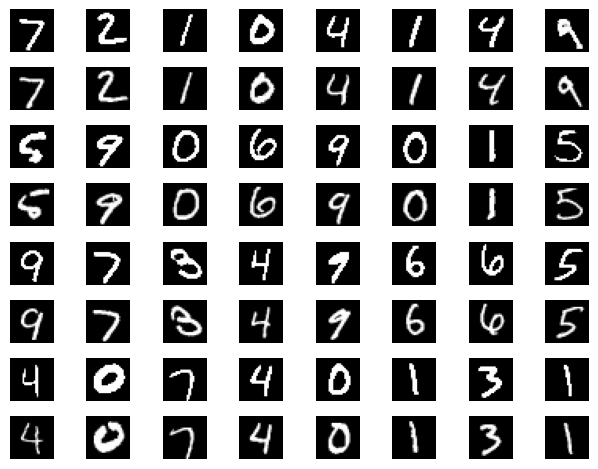

In [26]:
# ===Evaluation===
checkpoint = 'checkpoint/wae_gan/12232022-014704_wae_gan_epoch_100.pt'
state_dict = th.load(checkpoint, map_location=device)
encoder.load_state_dict(state_dict['e_state_dict'])
decoder.load_state_dict(state_dict['g_state_dict'])
discriminator.load_state_dict(state_dict['d_state_dict'])

encoder.eval()
decoder.eval()
discriminator.eval()

data = next(iter(mnist_test_loader))
with th.no_grad():
    reconstr = decoder.forward(encoder.forward(data[0].to(device)))

fig, axes = plt.subplots(8, 8, sharex=True, sharey=True)
for i, (x_true, x_reconstr) in enumerate(zip(reconstr[:32], data[0][:32])):
    x_true, x_reconstr = x_true.cpu().numpy(), x_reconstr.cpu().numpy()
    ax_1 = axes[2 * math.floor(i / 8), int(i % 8)]
    ax_1.imshow(
        x_true[0], origin='upper', cmap='binary_r'
    )
    ax_1.set_axis_off()

    ax_2 = axes[2 * math.floor(i / 8) + 1, int(i % 8)]
    ax_2.imshow(
        x_reconstr[0], origin='upper', cmap='binary_r'
    )
    ax_2.set_axis_off()

fig.tight_layout()
fig.savefig('../img/wae_gan.png', dpi=600)

#### WAE-MMD

TBD